In [1]:
# Шестая нейросеть. CNN для цветных изображений разного размера. Другой датасет

# Импорт всего важного
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import tensorflow_datasets as tfds
import math
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil

In [2]:
# Загрузка и распаковка датасета
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
zip_file = tf.keras.utils.get_file(origin=_URL, fname="flower_photos.tgz", extract=True)
base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

# Создание классов цветов датасета
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print(zip_file, base_dir)

In [3]:
# Выведет количество цветов в каждой папке

for cl in classes:
    img_path = os.path.join(base_dir, cl)
    images = glob.glob(img_path + '/*.jpg')
    print("{}: {} изображений".format(cl, len(images)))
    train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

    for t in train:
        if not os.path.exists(os.path.join(base_dir, 'train', cl)):
            os.makedirs(os.path.join(base_dir, 'train', cl))
        shutil.move(t, os.path.join(base_dir, 'train', cl))

    for v in val:
        if not os.path.exists(os.path.join(base_dir, 'val', cl)):
            os.makedirs(os.path.join(base_dir, 'val', cl))
        shutil.move(v, os.path.join(base_dir, 'val', cl))
        
# Создание директорий
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

daisy: 633 изображений
dandelion: 898 изображений
roses: 641 изображений
sunflowers: 699 изображений
tulips: 799 изображений


In [4]:
# Функция, которая возвращает изображения со случайными преобразованиями. Нужна для расширения тестовых данных

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


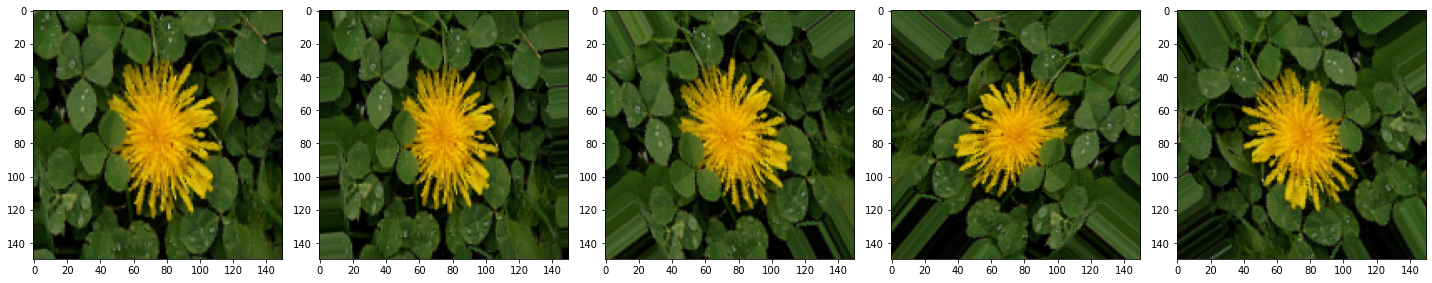

In [5]:
BATCH_SIZE = 100 # Количество тренировочных изображений для обработки перед обновлением параметров модели
IMG_SHAPE = 150 # Размерность 150x150 к которой будет преведено входное изображение

train_image_generator = ImageDataGenerator(rescale=1./255, rotation_range=45, zoom_range=0.2,
                                           horizontal_flip=True, fill_mode='nearest')
validation_image_generator = ImageDataGenerator(rescale=1./255)

# Загрузка данных
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                          directory=train_dir,
                                                          shuffle=True,
                                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                                          class_mode='binary')

# Валидационные данные
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=val_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                                              class_mode='binary')

# Вывод преобразований
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [6]:
# Создание модели
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Компиляция модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Представление модели
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 17, 17, 64)        0

In [7]:
# Тренировка моделей
EPOCHS = 80
history = model.fit_generator( # Используется fit_generator вместо обычного fit
    train_data_gen,
    steps_per_epoch=int(np.ceil(2900 / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(700 / float(BATCH_SIZE)))
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/80
29/29 [==============================] - 22s 775ms/step - loss: 1.6875 - accuracy: 0.2910 - val_loss: 1.2683 - val_accuracy: 0.4771
Epoch 2/80
29/29 [==============================] - 23s 793ms/step - loss: 1.1978 - accuracy: 0.4988 - val_loss: 1.1872 - val_accuracy: 0.5186
Epoch 3/80
29/29 [==============================] - 23s 792ms/step - loss: 1.0707 - accuracy: 0.5587 - val_loss: 1.2199 - val_accuracy: 0.5200
Epoch 4/80
29/29 [==============================] - 23s 785ms/step - loss: 1.0098 - accuracy: 0.6021 - val_loss: 1.0210 - val_accuracy: 0.6000
Epoch 5/80
29/29 [==============================] - 23s 781ms/step - loss: 0.9626 - accuracy: 0.6187 - val_loss: 0.9248 - val_accuracy: 0.6243
Epoch 6/80
29/29 [==============================] - 22s 771ms/step - loss: 0.8882 - accuracy: 0.6554 - val_loss: 0.9782 - val_accuracy: 0.6371
Epoch 7/80
29/29 [==============================] - 23s 780ms/step

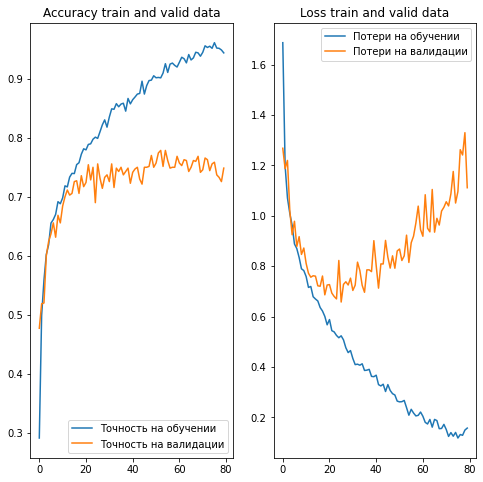

In [8]:
# Визуализация результатов тренировки
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на обучении')
plt.plot(epochs_range, val_acc, label='Точность на валидации')
plt.legend(loc='lower right')
plt.title('Accuracy train and valid data')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на обучении')
plt.plot(epochs_range, val_loss, label='Потери на валидации')
plt.legend(loc='upper right')
plt.title('Loss train and valid data')
plt.show()

In [9]:
# Сохраняем модель
model.save('Sixth_network_CNN_model.h5')